# Report

The goal is to identify which features are important and influence the buying intent of customers. There are 3 sets of feature and 2 models are trained on each set. The tree based model(Gradient boosted trees) will be used to determine feature importance. The model with the highest Balanced accuracy score will be selected. The neural netwrok based mode serves as reference for how good the tree based model is. Ideally the performance between the two models should be equal. 


## Model selection

The hyper parameter for each model is optimized using bayesian optimization and 5 fold  stratified Cross Validation. Each model is trained on there different transformations of the original dataset. Since the data set is imbalanced be use balanced accuracy as the metric.

### Optimization and selection for gradient boosted trees

In [1]:
# imports
import lightgbm as lgb #light gradient boosted tree
from sklearn.model_selection import train_test_split, StratifiedKFold # train and test split
from sklearn.metrics import balanced_accuracy_score,precision_score# metrics
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK# optimization
import numpy as np
import pandas as pd # reading data
import warnings
warnings.simplefilter("ignore")

In [2]:
# read data
df_encoded = pd.read_csv('/Users/HP/Downloads/online_shoppers_intention_encoded.csv', index_col=False)
df_scaled = pd.read_csv('/Users/HP/Downloads/online_shoppers_intention_encoded_scaled.csv', index_col=False)
df_transformed = pd.read_csv('/Users/HP/Downloads/online_shoppers_intention_encoded_scaled_transformed.csv', index_col=False)

In [3]:
#seperate label
label = df_encoded.pop('Revenue').astype('int')
_,_ = df_scaled.pop('Revenue'),df_transformed.pop('Revenue')

In [4]:
#split object for CV 
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
#Hyperparameter search space for gradient boosed trees
lgb_space = {'lr':hp.loguniform('lr',-6.9,-2.3),'num_leaves':hp.quniform('num_leaves',15,255,1),
         'max_depth':hp.choice('max_depth',[-1,9,12]),'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0)}

In [5]:
def lgb_optimizer(params):
    '''A function to optimize  lgb classifier
    :params:=params , dictionary containing the Hyper-parameters for the classifier
    returns true loss and validation loss
    '''
    if 'num_leaves' in params:
        params['num_leaves']=int(params['num_leaves'])
    if 'max_depth' in params:
        params['max_depth']=int(params['max_depth'])
    val_score=[]
    true_scores=[]
    rd=1
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
        clf = lgb.LGBMClassifier(n_estimators=2000,**params)
        clf.fit(X_tr,y_tr,eval_set=(X_val,y_val),early_stopping_rounds =200,eval_metric='logloss',verbose=False)
        y_pred = clf.predict(X_val)
        y_tr_pred=clf.predict(X_tr)
        score=balanced_accuracy_score(y_val,y_pred,)
        true_score=balanced_accuracy_score(y_tr,y_tr_pred)
        val_score.append(score)
        true_scores.append(true_score)
        rd+=1
    mean,std =np.mean(val_score),np.std(val_score)
    true_mean=np.mean(true_scores)
    print("mean: {}, Std: {}".format(mean,std))
    return {'loss':-mean,'status': STATUS_OK,'true_loss':-true_mean}

In [6]:
#split into train and test and call the fmin(optimizer) function for encoded dataset
X_train,X_test,y_train,y_test = train_test_split(df_encoded,label,test_size=0.2,random_state=42)
trials_encoded = Trials()
best_e= fmin(lgb_optimizer,lgb_space, algo=tpe.suggest, max_evals=20, trials=trials_encoded)

mean: 0.7713629479019699, Std: 0.014022656449164981                                                                    
mean: 0.780347780500698, Std: 0.015762279238775514                                                                     
mean: 0.7710274330388664, Std: 0.016409413555054896                                                                    
mean: 0.771373582703389, Std: 0.022747265106522828                                                                     
mean: 0.7248698142846253, Std: 0.015261198257772803                                                                    
mean: 0.7630016383342728, Std: 0.012187429265890006                                                                    
mean: 0.7879509699413774, Std: 0.010876119830070488                                                                    
mean: 0.7831192584881587, Std: 0.014550309308066956                                                                    
mean: 0.7856147690023656, Std: 0.0139354

In [7]:
#for scaled dataset
X_train,X_test,y_train,y_test = train_test_split(df_scaled,label,test_size=0.2,random_state=42)
trials_scaled = Trials()
best_scaled = fmin(lgb_optimizer, lgb_space, algo=tpe.suggest, max_evals=20, trials=trials_scaled)

mean: 0.7787378702654202, Std: 0.01093795296107058                                                                     
mean: 0.754637217056172, Std: 0.01431626225654564                                                                      
mean: 0.7816760746960459, Std: 0.0074380866995027795                                                                   
mean: 0.7526548700767182, Std: 0.01655363420291347                                                                     
mean: 0.7555656064773564, Std: 0.013372533498388892                                                                    
mean: 0.7734443197538624, Std: 0.015793656323519624                                                                    
mean: 0.7750385527172481, Std: 0.012205536082764699                                                                    
mean: 0.7718812851238999, Std: 0.008365688619768406                                                                    
mean: 0.77190147999945, Std: 0.017268533

In [9]:
#for transformed dataset
X_train,X_test,y_train,y_test = train_test_split(df_transformed,label,test_size=0.2,random_state=42)
trials_transformed = Trials()
best_transformed = fmin(lgb_optimizer, lgb_space, algo=tpe.suggest, max_evals=20, trials=trials_transformed)

mean: 0.7556790901808667, Std: 0.017191758097012653                                                                    
mean: 0.7693387302971871, Std: 0.013241904437937397                                                                    
mean: 0.775091676737028, Std: 0.006264268835771365                                                                     
mean: 0.7512313562933406, Std: 0.019723296194634834                                                                    
mean: 0.7642284895207841, Std: 0.007357532261403563                                                                    
mean: 0.7570160259334193, Std: 0.017369838286645685                                                                    
mean: 0.7800906270033978, Std: 0.01377275678014378                                                                     
mean: 0.7601200507871128, Std: 0.008949656580634999                                                                    
mean: 0.768041553205874, Std: 0.01316753

In [10]:
def model_trainer(Data,label,params,classifier='lgb',test_size=0.2):
    '''A function to train a model. 
    parameters:
    Data :=pandas dataset or numpy array of features
    label:=pandas dataset or numpy array of labels for features 
    params:=python dict parametes for the model
    model:=keras model object or sklearn classifier object
    test_size:=Float (0,1) fraction for test split
    return
    model:=str 'keras','lgb'
    train_score:=float balanced accuracy train score
    test_score:=float balanced accuracy test score
    returns-trained model,train_score,test_score
    '''
    X_train,X_test,y_train,y_test = train_test_split(Data,label,test_size=test_size,random_state=42)
    if classifier=='lgb':
        if 'num_leaves' in params:
            params['num_leaves']=int(params['num_leaves'])
        if 'max_depth' in params:
            #max_depth=[-1,9,12]#max_depth choice list
            params['max_depth']=-1#int(params['max_depth'])#best returns an index corresponding the choice
        clf = lgb.LGBMClassifier(n_estimators=5000,**params)
        clf.fit(X_train,y_train,eval_set=(X_test,y_test),early_stopping_rounds =200,eval_metric='auc',verbose=False)
        train_pred=clf.predict(X_train)
        test_pred=clf.predict(X_test)
    elif classifier=='keras':
        opt=['adam','sgd']
        if 'optimizer' in params:
            params['optimizer'] =opt[params['optimizer']]
        clf = model(feature_size=X_train.shape[-1],**params)
        clf.fit(X_train,y_train,epochs=20,batch_size=128,verbose=0)
        train_pred=np.round(clf.predict(X_train))
        test_pred=np.round(clf.predict(X_test))
    train_score = balanced_accuracy_score(train_pred,y_train)
    test_score= balanced_accuracy_score(test_pred,y_test)
    return clf,train_score,test_score
        
    

In [11]:
print(best_e)
print(best_scaled)
print(best_transformed)

{'colsample_bytree': 0.4689966115050747, 'lr': 0.004186154212450494, 'max_depth': 2, 'num_leaves': 19.0}
{'colsample_bytree': 0.7188856959407939, 'lr': 0.0050239777912343825, 'max_depth': 2, 'num_leaves': 40.0}
{'colsample_bytree': 0.8825849809832234, 'lr': 0.05750543680313465, 'max_depth': 2, 'num_leaves': 16.0}


In [12]:
clf_encoded,lgb_train_encoded,lgb_test_encoded=model_trainer(df_encoded,label,best_e)
clf_scaled,lgb_train_scaled,lgb_test_scaled=model_trainer(df_scaled,label,best_scaled)
clf_transformed,lgb_train_transformed,lgb_test_transformed=model_trainer(df_transformed,label,best_transformed)

In [13]:
print("results")
print("| Dataset Type | Train Score | Test Score |")
print("| Encoded      | {:2f}       | {:2f}     |".format(lgb_train_encoded,lgb_test_encoded))
print("| Scaled       | {:2f}       | {:2f}     |".format(lgb_train_scaled,lgb_test_scaled))
print("| Transformed  | {:2f}       | {:2f}     |".format(lgb_train_scaled,lgb_test_scaled))

results
| Dataset Type | Train Score | Test Score |
| Encoded      | 0.894319       | 0.811391     |
| Scaled       | 0.909196       | 0.845628     |
| Transformed  | 0.909196       | 0.845628     |


### optimization and selection for neural network

In [14]:

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.optimizers import Adam, SGD
from tensorflow.python.keras.callbacks import EarlyStopping

In [15]:
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)

In [16]:
def model(feature_size,lr=0.1,optimizer='adam',hl_size=128):
    ''' function to define keras model
    :feature:=
    '''
    if optimizer=='adam':
        opt =Adam(lr=lr)
    elif optimizer=='sgd':
        opt = SGD(lr=lr)
    hl_size=int(hl_size)
    model =Sequential()
    model.add(Dense(hl_size,activation='relu',input_shape=(feature_size,)))
    model.add(Dropout(0.25))
    model.add(Dense(hl_size,activation='relu'))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])
    return model
    

In [17]:
def keras_optimizer(params):
    val_score=[]
    true_scores=[]
    rd=1
    for train_index, test_index in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[test_index]
        nn_model = model(X_train.shape[1],**params)
        cb = EarlyStopping(monitor='val_acc',min_delta=0.001,patience=3)
        nn_model.fit(X_tr,y_tr,validation_data=(X_val,y_val),batch_size=128,callbacks=[cb],epochs=50,verbose=0)
        #_,score= nn_model.evaluate(X_val,y_val)
        #_,true_score=nn_model.evaluate(X_tr,y_tr)
        cv_pred = np.round(nn_model.predict(X_val))
        score=balanced_accuracy_score(y_val,cv_pred)
        y_tr_pred = np.round(nn_model.predict(X_tr))
        true_score=balanced_accuracy_score(y_tr,y_tr_pred)
        
        val_score.append(score)
        true_scores.append(true_score)
        rd+=1
    mean,std =np.mean(val_score),np.std(val_score)
    true_mean=np.mean(true_scores)
    print("mean: {}, Std: {}".format(mean,std))
    return {'loss':-mean,'status': STATUS_OK,'true_loss':-true_mean}

In [18]:
keras_space = {'lr':hp.loguniform('lr',-10,-2.3),'optimizer':hp.choice('optimizer',['adam','sgd'])}

In [20]:
X_train,X_test,y_train,y_test = train_test_split(df_encoded,label,test_size=0.2,random_state=42)
best_nn_encoded=fmin(keras_optimizer,keras_space,algo=tpe.suggest,max_evals=10)

mean: 0.7086648325487408, Std: 0.07723872840502996                                                                     
mean: 0.6171397695334809, Std: 0.04880126245239854                                                                     
mean: 0.5454720677128179, Std: 0.0729035793995225                                                                      
mean: 0.5799615472573834, Std: 0.03360333448674164                                                                     
mean: 0.5009075009716284, Std: 0.001186335657067173                                                                    
mean: 0.5004847769878393, Std: 0.001178616909500873                                                                    
mean: 0.6623623880440338, Std: 0.0697524958173388                                                                      
mean: 0.6592444417229129, Std: 0.06523394754834763                                                                     
mean: 0.5988328961526014, Std: 0.0136286

In [21]:
X_train,X_test,y_train,y_test = train_test_split(df_scaled,label,test_size=0.2,random_state=42)
best_nn_scaled=fmin(keras_optimizer,keras_space,algo=tpe.suggest,max_evals=10)

mean: 0.7219638704178815, Std: 0.021954436950303195                                                                    
mean: 0.7354628887919691, Std: 0.013861708043929562                                                                    
mean: 0.501937033477755, Std: 0.0026214705544049923                                                                    
mean: 0.7171683185391707, Std: 0.026080430368878662                                                                    
mean: 0.7273322894315568, Std: 0.01796457474690111                                                                     
mean: 0.5021870700309796, Std: 0.00423234901273516                                                                     
mean: 0.5, Std: 0.0                                                                                                    
mean: 0.7375225973909121, Std: 0.014545876306617859                                                                    
mean: 0.5, Std: 0.0                     

In [22]:
X_train,X_test,y_train,y_test = train_test_split(df_transformed,label,test_size=0.2,random_state=42)
best_nn_transformed=fmin(keras_optimizer,keras_space,algo=tpe.suggest,max_evals=10)

mean: 0.5010472842516212, Std: 0.001413357299691906                                                                    
mean: 0.7747693585252742, Std: 0.011767663859868202                                                                    
mean: 0.7774581574925363, Std: 0.017763871163451114                                                                    
mean: 0.5104811279137919, Std: 0.0035720522366064567                                                                   
mean: 0.5060905357765467, Std: 0.012332225726712694                                                                    
mean: 0.5, Std: 0.0                                                                                                    
mean: 0.794206551337598, Std: 0.015221384021555906                                                                     
mean: 0.5, Std: 0.0                                                                                                    
mean: 0.501289285343844, Std: 0.00120671

In [23]:
print(best_nn_encoded)
print(best_nn_scaled)
print(best_nn_transformed)

{'lr': 0.0007622296280598096, 'optimizer': 0}
{'lr': 0.015542263054046233, 'optimizer': 0}
{'lr': 0.009366074941875552, 'optimizer': 0}


In [24]:
_,nn_train_encoded,nn_test_encoded=model_trainer(df_encoded,label,best_nn_encoded,'keras')
_,nn_train_scaled,nn_test_scaled=model_trainer(df_scaled,label,best_nn_scaled,'keras')
_,nn_train_transformed,nn_test_transformed=model_trainer(df_transformed,label,best_nn_transformed,'keras')

In [25]:
print("|              |        neural network            |       Boosted Trees       |")
print("| Dataset Type | Train Score     | Test Score     |Train Score   | Test Score |")
print("| Encoded      | {:.4f}          | {:.4f}         | {:.4f}       | {:.4f}     |".format(nn_train_encoded,nn_test_encoded,lgb_train_encoded,lgb_test_encoded))
print("| Scaled       | {:.4f}          | {:.4f}         | {:.4f}       | {:.4f}     |".format(nn_train_scaled,nn_test_scaled,lgb_train_scaled,lgb_test_scaled))
print("| Transformed  | {:.4f}          | {:.4f}         | {:.4f}       | {:.4f}     |".format(nn_train_scaled,nn_test_scaled,lgb_train_scaled,lgb_test_scaled))

|              |        neural network            |       Boosted Trees       |
| Dataset Type | Train Score     | Test Score     |Train Score   | Test Score |
| Encoded      | 0.7690          | 0.7374         | 0.8943       | 0.8114     |
| Scaled       | 0.8696          | 0.7937         | 0.9092       | 0.8456     |
| Transformed  | 0.8696          | 0.7937         | 0.9092       | 0.8456     |


The best result for both tree based model and neural network model are obtained on the feature set that is not scaled or transfromed. Both models perform equally well with the neural netwrok performing 1 percent better than the gradient boosted trees.

In [26]:
#Save the model
from sklearn.externals import joblib
joblib.dump(clf_encoded, 'lgb_best.pkl')

['lgb_best.pkl']

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

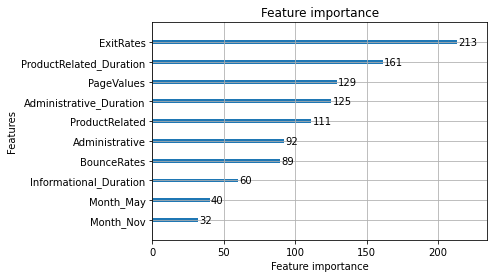

In [27]:
#feature importance for the best tree based model
%matplotlib inline
lgb.plot_importance(clf_encoded,max_num_features=10)

## Conclusion

The top 10 features affecting the buying intentions were identified. These features can be further isolated depending upon the applications. For eg. Exit would be a good measure of how well personalized webpages are working for users. A simple A/B test can be carried out with and without personalization and exit rates as well as other features can be monitored. Change in these features would indicate a change in buying intent and tell us if the test was succesfull. 